In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

### Подготовка данных для использования
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [2]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

In [3]:
BATCH_SIZE = 64

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([4, 6, 2, 1, 8, 8, 2, 1, 9, 9, 8, 1, 2, 0, 6, 0, 6, 0, 4, 7, 3, 5, 8, 4,
        7, 5, 1, 9, 2, 1, 9, 6, 1, 8, 9, 3, 5, 3, 3, 0, 0, 1, 3, 3, 8, 1, 3, 5,
        5, 6, 1, 2, 9, 2, 1, 4, 1, 4, 4, 7, 9, 7, 1, 1])

In [6]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

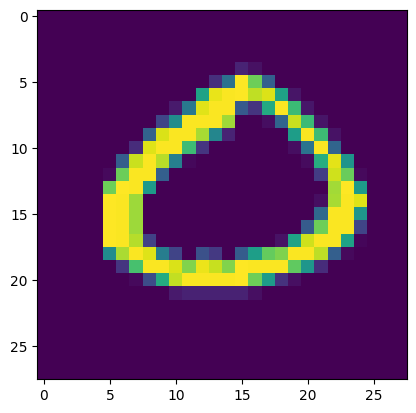

In [7]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Построим нейронную сеть, чтобы для решения задачи классификации

In [8]:
class multiClassNN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=0.3)
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 128)
        self.Linear3 = torch.nn.Linear(128, 64)
        self.Linear4 = torch.nn.Linear(64, 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x)
        x = self.relu(x)
        x = self.Linear4(x).squeeze(1)
        x = self.softmax(x)
        return x

In [9]:
class multiClassNNdropout(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=0.3)
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 128)
        self.Linear3 = torch.nn.Linear(128, 64)
        self.Linear4 = torch.nn.Linear(64, 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x)
        x = self.relu(x)
        x = self.Linear4(x).squeeze(1)
        x = self.softmax(x)
        return x

In [10]:
model = multiClassNN()
model_dropout = multiClassNNdropout()

### Функция, вычисляющая лосс

In [11]:
def loss_function(true, pred):
    loss = torch.nn.CrossEntropyLoss()
    return loss(pred, true)

### Оптимизатор

In [12]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

### Построим процесс обучения нейронной сети

In [13]:
NUM_EPOCHS = 100

In [14]:
def make_calculations(model, num_epochs=NUM_EPOCHS):
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(num_epochs)):
        model.train(True)
        train_loss_epoch = 0
        test_loss_epoch = 0

        for X, y in train_dataloader:
            y_true = []
            for i in y:
                row = [0 for i in range(10)]
                row[i] = 1
                y_true.append(row)
            model.zero_grad()
            y_true = torch.FloatTensor(y_true)
            train_predictions = model.forward(X)
            loss_value = loss_function(y_true, train_predictions)
            loss_value.backward()
            train_loss_epoch += loss_value.item()/len(train_dataloader)
            optimizer.step()
        train_loss.append(train_loss_epoch)
        model.train(False)

        for X, y in test_dataloader:
            y_true = []
            for i in y:
              row = [0 for i in range(10)]
              row[i] = 1
              y_true.append(row)
            y_true = torch.FloatTensor(y_true)
            test_predictions = model.forward(X)
            loss_value = loss_function(y_true, test_predictions)
            test_loss_epoch += loss_value.item()/len(test_dataloader)
        test_loss.append(test_loss_epoch)

    return train_loss, test_loss

In [15]:
def make_predictions(model):
    test_class_nums_true = []
    test_class_nums_preds= []

    for X, y in test_dataloader:
        y_true = []
        for i in y:
            row = [0 for i in range(10)]
            row[i] = 1
            y_true.append(row)
        test_class_nums_true = test_class_nums_true + y.tolist()
        y_true = torch.FloatTensor(y_true)
        test_predictions = model.forward(X)
        test_class_nums_preds = test_class_nums_preds + test_predictions.argmax(dim=1).tolist()

    return test_class_nums_true, test_class_nums_preds

In [16]:
def loss_graphs(train_loss, test_loss):
    plt.ylim(min(train_loss + test_loss)-0.01, max(train_loss + test_loss) + 0.01)
    plt.xticks(np.arange(0, NUM_EPOCHS+1, 10))
    plt.title('Train vs Test Loss')
    plt.xlabel('epoch index')
    plt.ylabel('cross entropy')
    sns.lineplot(train_loss, color='red')
    sns.lineplot(test_loss, color='green')

In [17]:
train_loss, test_loss = make_calculations(model)

100%|██████████| 100/100 [14:54<00:00,  8.95s/it]


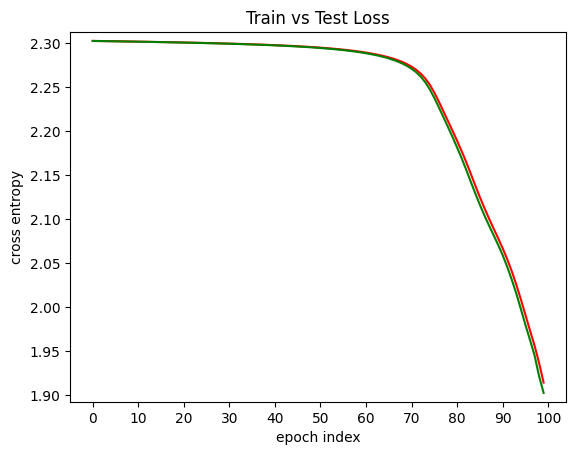

In [18]:
loss_graphs(train_loss, test_loss)

In [19]:
test_class_nums_true, test_class_nums_preds = make_predictions(model)

In [20]:
class_names = []
for i in range(10):
    class_name = 'number_' + str(i)
    class_names.append(class_name)

print(classification_report(test_class_nums_true, test_class_nums_preds, target_names=class_names))

              precision    recall  f1-score   support

    number_0       0.72      0.95      0.81       980
    number_1       0.82      0.97      0.89      1131
    number_2       0.00      0.00      0.00      1031
    number_3       0.58      0.85      0.69      1010
    number_4       0.50      0.93      0.65       978
    number_5       0.00      0.00      0.00       892
    number_6       0.68      0.90      0.78       957
    number_7       0.69      0.87      0.77      1026
    number_8       0.44      0.68      0.54       974
    number_9       0.00      0.00      0.00      1005

    accuracy                           0.62      9984
   macro avg       0.44      0.61      0.51      9984
weighted avg       0.45      0.62      0.52      9984



In [23]:
train_loss_2, test_loss_2 = make_calculations(model_dropout)

100%|██████████| 100/100 [15:11<00:00,  9.12s/it]


In [24]:
test_class_nums_true_2, test_class_nums_preds_2 = make_predictions(model_dropout)

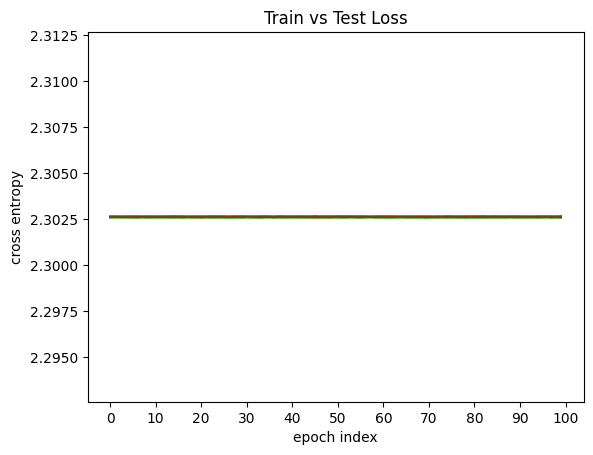

In [25]:
loss_graphs(train_loss_2, test_loss_2)

In [26]:
print(classification_report(test_class_nums_true_2, test_class_nums_preds_2, target_names=class_names))

              precision    recall  f1-score   support

    number_0       0.00      0.00      0.00       978
    number_1       0.00      0.00      0.00      1133
    number_2       0.00      0.00      0.00      1030
    number_3       0.00      0.00      0.00      1007
    number_4       0.10      1.00      0.18       981
    number_5       0.00      0.00      0.00       892
    number_6       0.00      0.00      0.00       957
    number_7       0.00      0.00      0.00      1028
    number_8       0.00      0.00      0.00       972
    number_9       0.00      0.00      0.00      1006

    accuracy                           0.10      9984
   macro avg       0.01      0.10      0.02      9984
weighted avg       0.01      0.10      0.02      9984



**Вывод**: качество модели довольно низкое, а добавление dropout значительно ухудшило качество модели. Текущая модель в силу своей простоты не отлавливает сложных зависимостей, например, зависимость местоположения одних точек относительно других, необходимо дальнейшая доработка модели, в том числе с пересмотром архитектуры нейросети.